In [ ]:
import pandas as pd
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
import pt_core_news_md
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

# Base de dados

A base de dados escolhida esta no seguinte link: https://drive.google.com/file/d/1BapYHUouIOp2wiI2698gi8OzvsRACocz/view?usp=drive_link, é uma base de produtos de um

In [ ]:
prod = pd.read_csv('produtos.csv', delimiter=';')
prod.head()

,nome,descricao,categoria
0,O Hobbit - 7ª Ed. 2013,Produto NovoBilbo Bolseiro é um hobbit que lev...,livro
1,Livro - It A Coisa - Stephen King,Produto NovoDurante as férias escolares de 195...,livro
2,Box As Crônicas De Gelo E Fogo Pocket 5 Li...,Produto NovoTodo o reino de Westeros ao alcanc...,livro
3,Box Harry Potter,Produto Novo e Físico A série Harry Potter ch...,livro
4,Livro Origem - Dan Brown,Produto NovoDe Onde Viemos? Para Onde Vamos? R...,livro


In [ ]:
prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2916 entries, 0 to 4079
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   categoria    2916 non-null   object
 1   concatenado  2916 non-null   object
 2   limpo        2916 non-null   object
 3   mais_limpo   2916 non-null   object
 4   tokens_l     2916 non-null   object
 5   tokens_ml    2916 non-null   object
 6   lemma_l      2916 non-null   object
 7   lemma_ml     2916 non-null   object
dtypes: object(8)
memory usage: 205.0+ KB


# Limpeza da Base

In [ ]:
prod.isna().mean().round(4).mul(100)

nome          0.00
descricao    28.53
categoria     0.00
dtype: float64

A base, por mais que seja balanceada, muitos produtos não possuem descrição e isso pode ser um problema para a análise

Assim temos algumas opções:
- Descartar a coluna descrição e perder muita informação e utilizar apenas o nome do produtos
- Descartar os dados sem descrição e dimuir os dados
- Manter todos e ter amostras com menos informações

A fim de não ter diferenças nos dados e garantir o máximo de informação iremos descartar os dados sem descrição

In [ ]:
prod = prod.dropna()

prod.isna().mean().round(4).mul(100)

nome         0.0
descricao    0.0
categoria    0.0
dtype: float64

In [ ]:
prod['categoria'].unique()

array(['livro', 'brinquedo', 'maquiagem', 'game'], dtype=object)

In [ ]:
prod['categoria'].value_counts()

livro        838
maquiagem    788
brinquedo    668
game         622
Name: categoria, dtype: int64

# Processamento da Base

Para processar o texto, primeiro vamos concatenar as colunas de texto

In [ ]:
prod['concatenado'] = prod['nome'] + ' ' + prod['descricao']
prod.drop(columns= ['nome', 'descricao'], inplace=True)
prod.head()

,categoria,concatenado
0,livro,O Hobbit - 7ª Ed. 2013 Produto NovoBilbo Bol...
1,livro,Livro - It A Coisa - Stephen King Produto No...
2,livro,Box As Crônicas De Gelo E Fogo Pocket 5 Li...
3,livro,Box Harry Potter Produto Novo e Físico A sé...
4,livro,Livro Origem - Dan Brown Produto NovoDe Onde...


antes de processar o texto precisamos deixa-lo uniforme

In [ ]:
prod['concatenado'] = prod['concatenado'].str.lower()
prod['concatenado']

0        o hobbit - 7ª ed. 2013  produto novobilbo bol...
1        livro - it a coisa - stephen king  produto no...
2        box  as crônicas de gelo e fogo  pocket  5 li...
3        box harry potter  produto novo e físico  a sé...
4        livro origem - dan brown  produto novode onde...
                              ...                        
4073     red dead redemption edição do ano goty xbox 3...
4074     jogo gta 5 grand theft auto v ps4 mídia cd + ...
4075     zelda: breath of the wild - expansion pass - ...
4078     gta san andreas hd remastered ps3 envio imedi...
4079     mini game  nova portátil 10mil jogos player m...
Name: concatenado, Length: 2916, dtype: object

remoção de stop words

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
stop_words = set(nltk.corpus.stopwords.words('portuguese'))

In [ ]:
def remove_stop_words(sentence):
    global stop_words

    words = nltk.tokenize.word_tokenize(sentence, language= 'portuguese')
    cleaned = [word for word in words if word.lower().strip() not in stop_words]


    return ' '.join(cleaned)

In [ ]:
prod['limpo'] = prod['concatenado'].apply(remove_stop_words)

In [ ]:
prod.head()

,categoria,concatenado,limpo,mais_limpo,tokens_l,tokens_ml,lemma_l,lemma_ml
0,livro,o hobbit - 7ª ed. 2013 produto novobilbo bol...,hobbit - 7ª ed. 2013 novobilbo bolseiro hobbit...,hobbit - 7ª ed. 2013 novobilbo bolseiro hobbit...,"[hobbit, 7ª, ed, 2013, produto, novobilbo, bol...","[hobbit, 7ª, ed, 2013, novobilbo, bolseiro, ho...","[hobbit, -, 7ª, ed., 2013, produto, novobilbo,...","[hobbit, -, 7ª, ed., 2013, novobilbo, Bolseiro..."
1,livro,livro - it a coisa - stephen king produto no...,livro - it coisa - stephen king novodurante fé...,livro - it coisa - stephen king novodurante fé...,"[livro, it, coisa, stephen, king, produto, nov...","[livro, it, coisa, stephen, king, novodurante,...","[livro, -, it, coisa, -, Stephen, King, produt...","[livro, -, it, coisa, -, Stephen, King, novodu..."
2,livro,box as crônicas de gelo e fogo pocket 5 li...,box crônicas gelo fogo pocket 5 livros novotod...,box crônicas gelo fogo pocket 5 livros novotod...,"[box, crônicas, gelo, fogo, pocket, 5, livros,...","[box, crônicas, gelo, fogo, pocket, 5, livros,...","[box, crônica, gelo, Fogo, pocket, 5, livro, p...","[box, crônica, gelo, Fogo, pocket, 5, livro, n..."
3,livro,box harry potter produto novo e físico a sé...,box harry potter novo físico série harry potte...,box harry potter novo físico série harry potte...,"[box, harry, potter, produto, novo, físico, sé...","[box, harry, potter, novo, físico, série, harr...","[box, harry, potter, produto, novo, físico, sé...","[box, harry, potter, novo, físico, série, harr..."
4,livro,livro origem - dan brown produto novode onde...,livro origem - dan brown novode onde viemos ? ...,livro origem - dan brown novode onde viemos ? ...,"[livro, origem, dan, brown, produto, novode, o...","[livro, origem, dan, brown, novode, onde, viem...","[livro, origem, -, dan, Brown, produto, novode...","[livro, origem, -, dan, brown, novode, onde, v..."


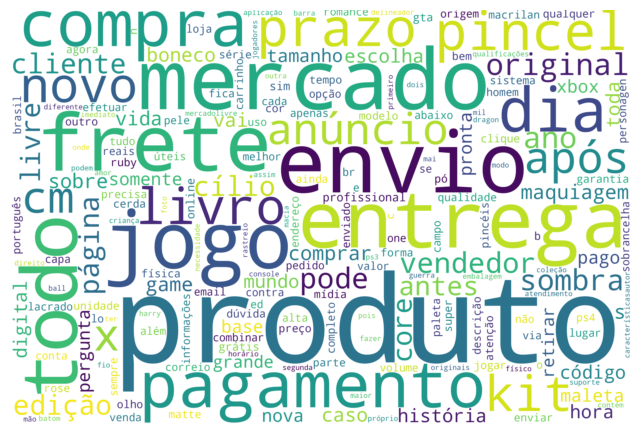

In [ ]:
text = ' '.join(prod['limpo'].astype(str))
word_cloud = WordCloud(width=3000,
                        height=2000,
                        random_state=1,
                        background_color='white',
                        collocations=False).generate(text)

# Display the generated image:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

algumas palavras bem recorrentes não definem o produto, assim podemos remove-las já que não nos ajudam como:

In [ ]:
redundantes = {'produto', 'frete', 'mercado', 'compra', 'pagamento', 'entrega', 'envio', 'anúncio', 'cliente', 'vendedor', 'prazo'}

In [ ]:
stop_words = stop_words.union(redundantes)

In [ ]:
prod['mais_limpo'] = prod['concatenado'].apply(remove_stop_words)

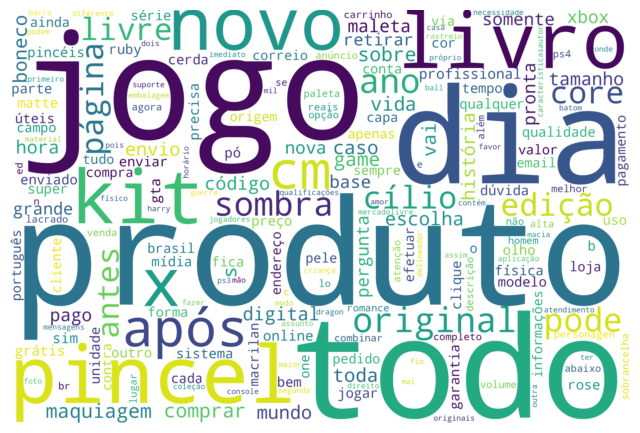

In [ ]:
text = ' '.join(prod['mais_limpo'].astype(str))
word_cloud = WordCloud(width=3000,
                        height=2000,
                        random_state=1,
                        background_color='white',
                        collocations=False).generate(text)

# Display the generated image:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [ ]:
tokenizer = nltk.RegexpTokenizer(r"\w+")
prod['tokens_l'] = prod['limpo'].apply(tokenizer.tokenize)
prod['tokens_ml'] = prod['mais_limpo'].apply(tokenizer.tokenize)

In [ ]:
prod.head()

,categoria,concatenado,limpo,mais_limpo,tokens_l,tokens_ml
0,livro,o hobbit - 7ª ed. 2013 produto novobilbo bol...,hobbit - 7ª ed. 2013 produto novobilbo bolseir...,hobbit - 7ª ed. 2013 novobilbo bolseiro hobbit...,"[hobbit, 7ª, ed, 2013, produto, novobilbo, bol...","[hobbit, 7ª, ed, 2013, novobilbo, bolseiro, ho..."
1,livro,livro - it a coisa - stephen king produto no...,livro - it coisa - stephen king produto novodu...,livro - it coisa - stephen king novodurante fé...,"[livro, it, coisa, stephen, king, produto, nov...","[livro, it, coisa, stephen, king, novodurante,..."
2,livro,box as crônicas de gelo e fogo pocket 5 li...,box crônicas gelo fogo pocket 5 livros produto...,box crônicas gelo fogo pocket 5 livros novotod...,"[box, crônicas, gelo, fogo, pocket, 5, livros,...","[box, crônicas, gelo, fogo, pocket, 5, livros,..."
3,livro,box harry potter produto novo e físico a sé...,box harry potter produto novo físico série har...,box harry potter novo físico série harry potte...,"[box, harry, potter, produto, novo, físico, sé...","[box, harry, potter, novo, físico, série, harr..."
4,livro,livro origem - dan brown produto novode onde...,livro origem - dan brown produto novode onde v...,livro origem - dan brown novode onde viemos ? ...,"[livro, origem, dan, brown, produto, novode, o...","[livro, origem, dan, brown, novode, onde, viem..."


lematizando as tokens

In [ ]:
nlp = spacy.load('pt_core_news_lg')

In [ ]:
lemmatize_func = lambda words: [token.lemma_ for token in nlp(str(words))]

prod['lemma_l'] = prod['limpo'].apply(lemmatize_func)
prod['lemma_ml'] = prod['mais_limpo'].apply(lemmatize_func)

prod.head()


,categoria,concatenado,limpo,mais_limpo,tokens_l,tokens_ml,lemma_l,lemma_ml
0,livro,o hobbit - 7ª ed. 2013 produto novobilbo bol...,hobbit - 7ª ed. 2013 novobilbo bolseiro hobbit...,hobbit - 7ª ed. 2013 novobilbo bolseiro hobbit...,"[hobbit, 7ª, ed, 2013, novobilbo, bolseiro, ho...","[hobbit, 7ª, ed, 2013, novobilbo, bolseiro, ho...","[hobbit, -, 7ª, ed., 2013, novobilbo, Bolseiro...","[hobbit, -, 7ª, ed., 2013, novobilbo, Bolseiro..."
1,livro,livro - it a coisa - stephen king produto no...,livro - it coisa - stephen king novodurante fé...,livro - it coisa - stephen king novodurante fé...,"[livro, it, coisa, stephen, king, novodurante,...","[livro, it, coisa, stephen, king, novodurante,...","[livro, -, it, coisa, -, Stephen, King, novodu...","[livro, -, it, coisa, -, Stephen, King, novodu..."
2,livro,box as crônicas de gelo e fogo pocket 5 li...,box crônicas gelo fogo pocket 5 livros novotod...,box crônicas gelo fogo pocket 5 livros novotod...,"[box, crônicas, gelo, fogo, pocket, 5, livros,...","[box, crônicas, gelo, fogo, pocket, 5, livros,...","[box, crônica, gelo, Fogo, pocket, 5, livro, n...","[box, crônica, gelo, Fogo, pocket, 5, livro, n..."
3,livro,box harry potter produto novo e físico a sé...,box harry potter novo físico série harry potte...,box harry potter novo físico série harry potte...,"[box, harry, potter, novo, físico, série, harr...","[box, harry, potter, novo, físico, série, harr...","[box, harry, potter, novo, físico, série, harr...","[box, harry, potter, novo, físico, série, harr..."
4,livro,livro origem - dan brown produto novode onde...,livro origem - dan brown novode onde viemos ? ...,livro origem - dan brown novode onde viemos ? ...,"[livro, origem, dan, brown, novode, onde, viem...","[livro, origem, dan, brown, novode, onde, viem...","[livro, origem, -, dan, brown, novode, onde, v...","[livro, origem, -, dan, brown, novode, onde, v..."


## Transformando em features

In [ ]:
def dummy(tokens):
    return tokens

vectorizer_l = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy)
vectorizer_ml = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy)

l = vectorizer_l.fit_transform(prod['lemma_l'].values)
ml = vectorizer_ml.fit_transform(prod['lemma_ml'].values)

# Base de dados limpa
l_tfidf_features = pd.DataFrame(l.todense(), columns=vectorizer_l.get_feature_names_out())

# Base de dados mais limpa
ml_tfidf_features = pd.DataFrame(ml.todense(), columns=vectorizer_ml.get_feature_names_out())

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


#

## Word-Embendding

In [ ]:
sentence_docs_l = prod['lemma_l'].apply(lambda x: spacy.tokens.Doc(nlp.vocab, words=x))

sentence_vectors = []

for doc in sentence_docs_l:
    # Calculate the average word vector for each sentence
    sentence_vector = np.mean([token.vector for token in doc], axis=0)
    sentence_vectors.append(sentence_vector)


# Base de dados limpa
l_we_features = np.array(sentence_vectors)

In [ ]:
sentence_docs_l = prod['lemma_ml'].apply(lambda x: spacy.tokens.Doc(nlp.vocab, words=x))

sentence_vectors = []

for doc in sentence_docs_l:
    # Calculate the average word vector for each sentence
    sentence_vector = np.mean([token.vector for token in doc], axis=0)
    sentence_vectors.append(sentence_vector)

# Base de dados mais limpa
ml_we_features = np.array(sentence_vectors)

# Realizando o PCA

Como estava demorando demais para rodar com 300 atributos, optamos por realizar um PCA a fim de diminuir o número de colunas da base

In [ ]:
pca = PCA(n_components=10, random_state=24)

# Aplicando o PCA em ml_tfidf_features

PCA_ml_tfidf_features = pca.fit_transform(ml_tfidf_features)

# Agrupamento

## Base: ml_tfidf_feature

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

# Utilizando o método do cotovelo para descobrir o melhor valor K (número de clusters)
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(2,11))
visualizer.fit(ml_tfidf_features)
visualizer.show()

In [ ]:
# Aplicando algoritmo hierárquico aglomerativo
def calculaDistanciaWard(dataset):
  matrizDistancias = linkage(dataset, method='ward')
  return matrizDistancias

# Plotar o dendrograma
matrizDistancias = calculaDistanciaWard(ml_tfidf_features)
plt.figure(figsize=(25, 10))
dend = dendrogram(matrizDistancias, truncate_mode="lastp", show_leaf_counts= True, show_contracted= True)
plt.title('Dendrograma Hierárquico')
plt.xlabel('Índices dos Pontos')
plt.ylabel('Distância')
plt.show()

In [ ]:
n_clusters = 5
clusterAglomerativo = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
y_clusterAglomerativo = clusterAglomerativo.fit_predict(_ml_tfidf_features)

unico, contagens = np.unique(y_clusterAglomerativo, return_counts=True)
total = sum(contagens)
porcentagemDosClusters = [f'{contagem/total*100:.2f}%' for contagem in contagens]
for i, porcentagem in enumerate(porcentagemDosClusters):
  print("O cluster {} possui {}% dos elementos" .format(i + 1, porcentagem))

O cluster 1 possui 67.80%% dos elementos
O cluster 2 possui 22.36%% dos elementos
O cluster 3 possui 3.43%% dos elementos
O cluster 4 possui 3.40%% dos elementos
O cluster 5 possui 3.02%% dos elementos


## Base: *ml_we_features*

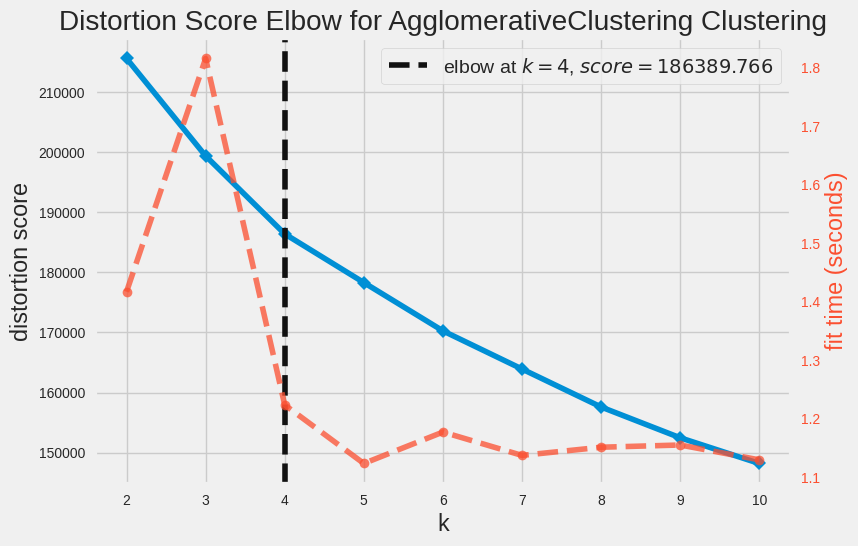

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

# Utilizando o método do cotovelo para descobrir o melhor valor K (número de clusters)
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(2,11))
visualizer.fit(ml_we_features)
visualizer.show()

In [ ]:
# Métricas para escolher os Clusters

silhouette_coefficients = []
davies_bouldin = []

linkages = ['ward', 'complete']

for k in range(2,11):
    #'''
    agg = AgglomerativeClustering (n_clusters = k, linkage=linkages[0])
    agg.fit(ml_we_features)#'''
    '''
    agg = AgglomerativeClustering (n_clusters = k, linkage=linkage[1] )
    agg.fit(ml_we_features)#'''
    score1 = silhouette_score(ml_we_features, agg.labels_,  metric='euclidean')
    score3 = davies_bouldin_score(ml_we_features, agg.labels_)

    silhouette_coefficients.append(score1)
    davies_bouldin.append(score3)

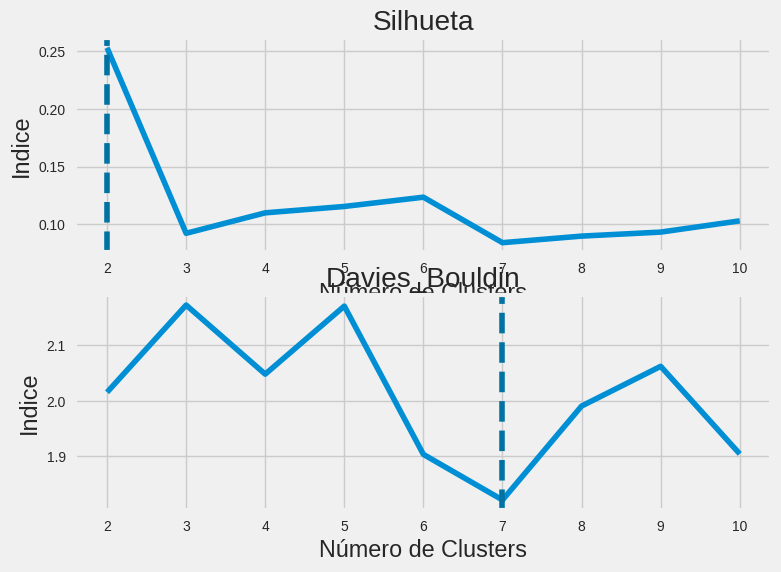

In [ ]:
# Demonstrando as métricas em gráficos - Ward

plt.figure(figsize = (8,9))

plt.subplot(311)
plt.style.use('fivethirtyeight')
plt.plot(range(2,11),silhouette_coefficients)
plt.xticks(range(2,11))
plt.xlabel('Número de Clusters')
plt.ylabel('Indice')
plt.axvline(x=2 , color ='b' ,label = 'axvline - full height' , ls='--')
plt.title('Silhueta')



plt.subplot(312)
plt.plot(range(2,11), davies_bouldin)
plt.xticks(range(2,11))
plt.xlabel('Número de Clusters')
plt.ylabel('Indice')
plt.axvline(x=7 , color ='b' ,label = 'axvline - full height' , ls='--')
plt.title('Davies_Bouldin')

plt.show()

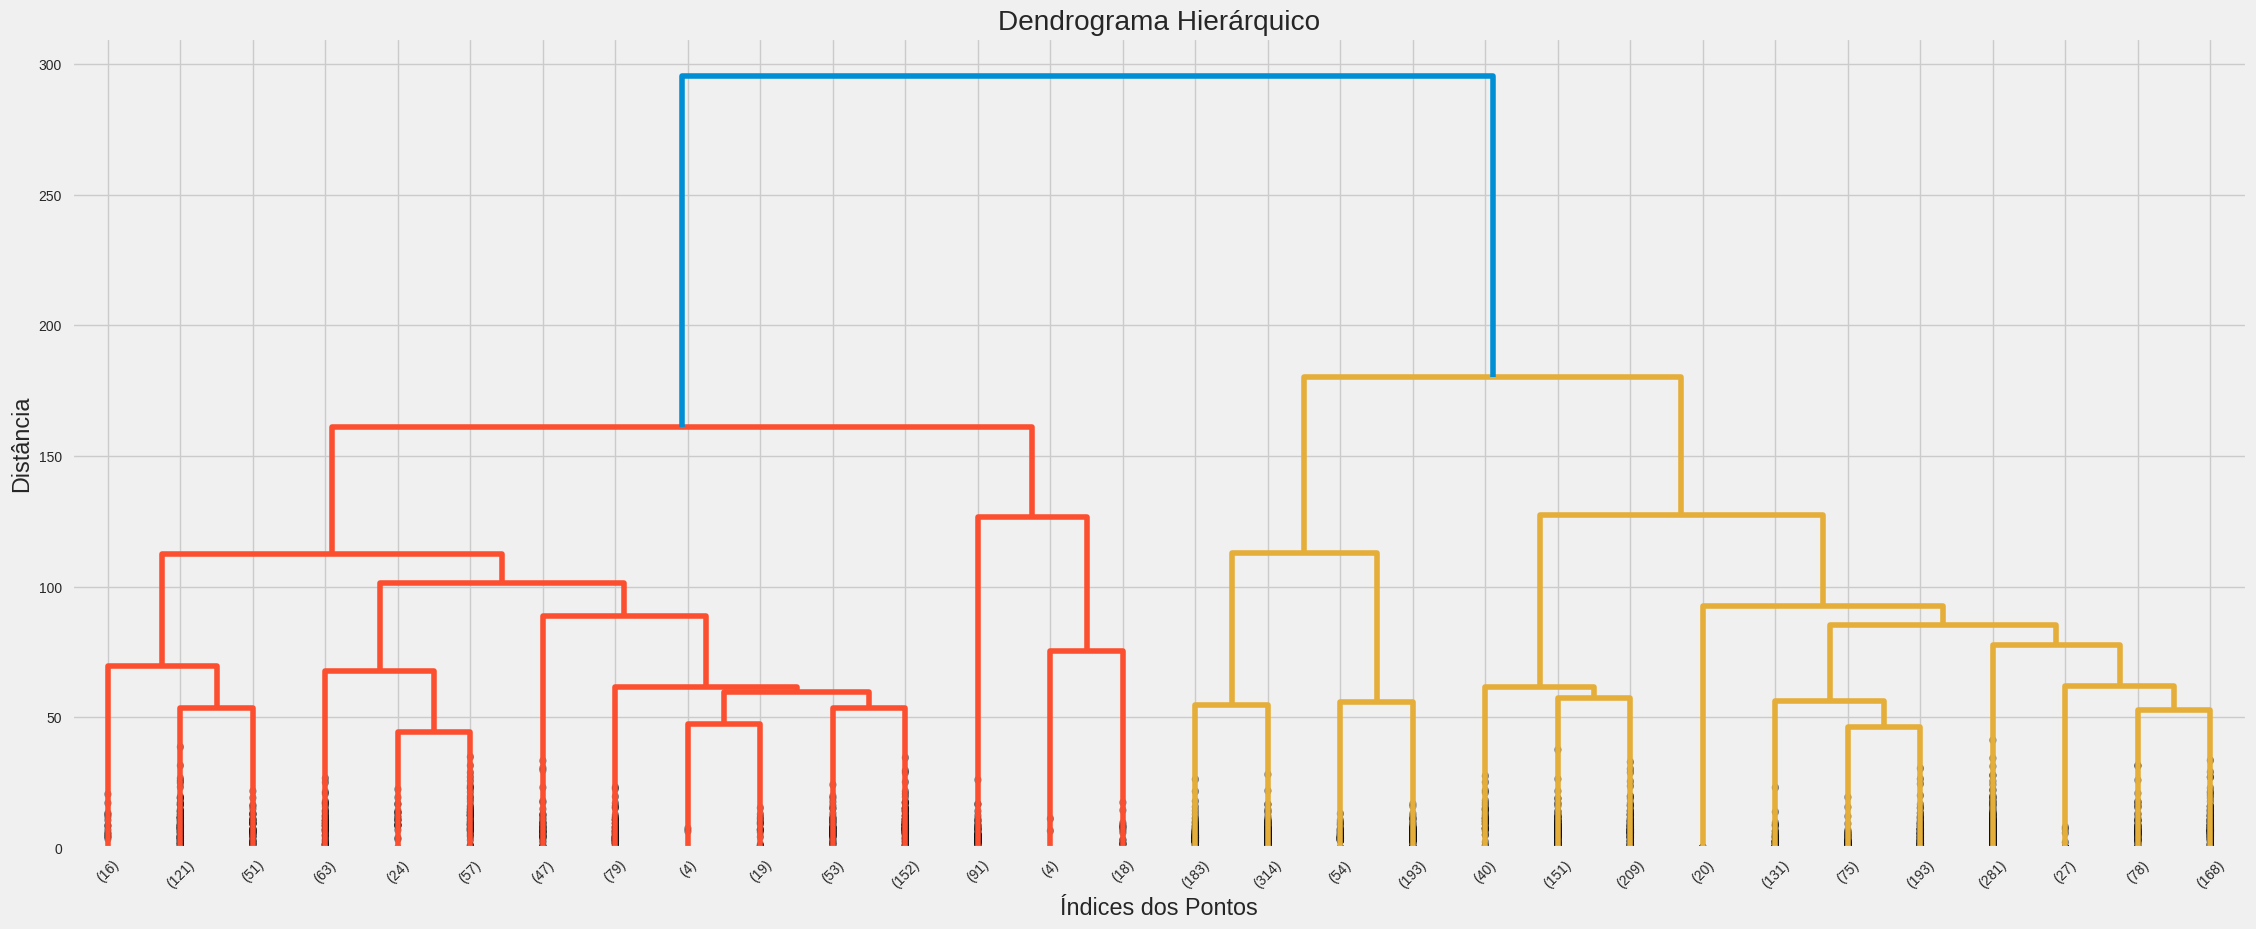

In [ ]:
# Aplicando algoritmo hierárquico aglomerativo
dist_matrix = linkage(ml_we_features, method='ward')
# Plotar o dendrograma
plt.figure(figsize=(25, 10))
dend = dendrogram(matrizDistancias, truncate_mode="lastp", show_leaf_counts= True, show_contracted= True)
plt.title('Dendrograma Hierárquico')
plt.xlabel('Índices dos Pontos')
plt.ylabel('Distância')
plt.show()

In [ ]:
n_clusters = 2 # Quantiddade de cluster encontrada pela validação da silhueta
clusterAglomerativo = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
y_clusterAglomerativo = clusterAglomerativo.fit_predict(ml_we_features)

unico, contagens = np.unique(y_clusterAglomerativo, return_counts=True)
total = sum(contagens)
porcentagemDosClusters = [f'{contagem/total*100:.2f}%' for contagem in contagens]
for i, porcentagem in enumerate(porcentagemDosClusters):
  print("O cluster {} possui {}% dos elementos" .format(i + 1, porcentagem))

n_clusters = 2 # Quantiddade de cluster encontrada pela validação da silhueta
clusterAglomerativo = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='complete')
y_clusterAglomerativo = clusterAglomerativo.fit_predict(ml_we_features)

unico, contagens = np.unique(y_clusterAglomerativo, return_counts=True)
total = sum(contagens)
porcentagemDosClusters = [f'{contagem/total*100:.2f}%' for contagem in contagens]
for i, porcentagem in enumerate(porcentagemDosClusters):
  print("O cluster {} possui {}% dos elementos" .format(i + 1, porcentagem))

n_clusters = 2 # Quantiddade de cluster encontrada pela validação da silhueta
clusterAglomerativo = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='single')
y_clusterAglomerativo = clusterAglomerativo.fit_predict(ml_we_features)

unico, contagens = np.unique(y_clusterAglomerativo, return_counts=True)
total = sum(contagens)
porcentagemDosClusters = [f'{contagem/total*100:.2f}%' for contagem in contagens]
for i, porcentagem in enumerate(porcentagemDosClusters):
  print("O cluster {} possui {}% dos elementos" .format(i + 1, porcentagem))

O cluster 1 possui 72.60%% dos elementos
O cluster 2 possui 27.40%% dos elementos
O cluster 1 possui 0.27%% dos elementos
O cluster 2 possui 99.73%% dos elementos
O cluster 1 possui 99.97%% dos elementos
O cluster 2 possui 0.03%% dos elementos


In [ ]:
n_clusters = 3 # Quantiddade de cluster encontrada pela validação da silhueta
clusterAglomerativo = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
y_clusterAglomerativo = clusterAglomerativo.fit_predict(ml_we_features)

unico, contagens = np.unique(y_clusterAglomerativo, return_counts=True)
total = sum(contagens)
porcentagemDosClusters = [f'{contagem/total*100:.2f}%' for contagem in contagens]
for i, porcentagem in enumerate(porcentagemDosClusters):
  print("O cluster {} possui {}% dos elementos" .format(i + 1, porcentagem))

n_clusters = 3 # Quantiddade de cluster encontrada pela validação da silhueta
clusterAglomerativo = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='complete')
y_clusterAglomerativo = clusterAglomerativo.fit_predict(ml_we_features)

unico, contagens = np.unique(y_clusterAglomerativo, return_counts=True)
total = sum(contagens)
porcentagemDosClusters = [f'{contagem/total*100:.2f}%' for contagem in contagens]
for i, porcentagem in enumerate(porcentagemDosClusters):
  print("O cluster {} possui {}% dos elementos" .format(i + 1, porcentagem))

O cluster 1 possui 27.40%% dos elementos
O cluster 2 possui 47.09%% dos elementos
O cluster 3 possui 25.51%% dos elementos
O cluster 1 possui 99.73%% dos elementos
O cluster 2 possui 0.14%% dos elementos
O cluster 3 possui 0.14%% dos elementos


In [ ]:
n_clusters = 4
clusterAglomerativo = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
y_clusterAglomerativo = clusterAglomerativo.fit_predict(ml_we_features)

unico, contagens = np.unique(y_clusterAglomerativo, return_counts=True)
total = sum(contagens)
porcentagemDosClusters = [f'{contagem/total*100:.2f}%' for contagem in contagens]
for i, porcentagem in enumerate(porcentagemDosClusters):
  print("O cluster {} possui {}% dos elementos" .format(i + 1, porcentagem))

n_clusters = 4
clusterAglomerativo = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='complete')
y_clusterAglomerativo = clusterAglomerativo.fit_predict(ml_we_features)

unico, contagens = np.unique(y_clusterAglomerativo, return_counts=True)
total = sum(contagens)
porcentagemDosClusters = [f'{contagem/total*100:.2f}%' for contagem in contagens]
for i, porcentagem in enumerate(porcentagemDosClusters):
  print("O cluster {} possui {}% dos elementos" .format(i + 1, porcentagem))

n_clusters = 4
clusterAglomerativo = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='single')
y_clusterAglomerativo = clusterAglomerativo.fit_predict(ml_we_features)

unico, contagens = np.unique(y_clusterAglomerativo, return_counts=True)
total = sum(contagens)
porcentagemDosClusters = [f'{contagem/total*100:.2f}%' for contagem in contagens]
for i, porcentagem in enumerate(porcentagemDosClusters):
  print("O cluster {} possui {}% dos elementos" .format(i + 1, porcentagem))

O cluster 1 possui 47.09%% dos elementos
O cluster 2 possui 3.88%% dos elementos
O cluster 3 possui 25.51%% dos elementos
O cluster 4 possui 23.53%% dos elementos
O cluster 1 possui 37.04%% dos elementos
O cluster 2 possui 62.69%% dos elementos
O cluster 3 possui 0.14%% dos elementos
O cluster 4 possui 0.14%% dos elementos
O cluster 1 possui 99.90%% dos elementos
O cluster 2 possui 0.03%% dos elementos
O cluster 3 possui 0.03%% dos elementos
O cluster 4 possui 0.03%% dos elementos


In [ ]:
n_clusters = 6
clusterAglomerativo = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
y_clusterAglomerativo = clusterAglomerativo.fit_predict(ml_we_features)

unico, contagens = np.unique(y_clusterAglomerativo, return_counts=True)
total = sum(contagens)
porcentagemDosClusters = [f'{contagem/total*100:.2f}%' for contagem in contagens]
for i, porcentagem in enumerate(porcentagemDosClusters):
  print("O cluster {} possui {}% dos elementos" .format(i + 1, porcentagem))

n_clusters = 6
clusterAglomerativo = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='complete')
y_clusterAglomerativo = clusterAglomerativo.fit_predict(ml_we_features)

unico, contagens = np.unique(y_clusterAglomerativo, return_counts=True)
total = sum(contagens)
porcentagemDosClusters = [f'{contagem/total*100:.2f}%' for contagem in contagens]
for i, porcentagem in enumerate(porcentagemDosClusters):
  print("O cluster {} possui {}% dos elementos" .format(i + 1, porcentagem))

O cluster 1 possui 25.51%% dos elementos
O cluster 2 possui 23.53%% dos elementos
O cluster 3 possui 0.75%% dos elementos
O cluster 4 possui 33.37%% dos elementos
O cluster 5 possui 13.72%% dos elementos
O cluster 6 possui 3.12%% dos elementos
O cluster 1 possui 0.41%% dos elementos
O cluster 2 possui 62.41%% dos elementos
O cluster 3 possui 0.27%% dos elementos
O cluster 4 possui 0.14%% dos elementos
O cluster 5 possui 36.63%% dos elementos
O cluster 6 possui 0.14%% dos elementos


In [ ]:
n_clusters = 7 # Quantiddade de cluster encontrado pelo Davie_Bouldins
clusterAglomerativo = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
y_clusterAglomerativo = clusterAglomerativo.fit_predict(ml_we_features)

unico, contagens = np.unique(y_clusterAglomerativo, return_counts=True)
total = sum(contagens)
porcentagemDosClusters = [f'{contagem/total*100:.2f}%' for contagem in contagens]
for i, porcentagem in enumerate(porcentagemDosClusters):
  print("O cluster {} possui {}% dos elementos" .format(i + 1, porcentagem))

n_clusters = 7 # Quantiddade de cluster encontrado pelo Davie_Bouldins
clusterAglomerativo = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='complete')
y_clusterAglomerativo = clusterAglomerativo.fit_predict(ml_we_features)

unico, contagens = np.unique(y_clusterAglomerativo, return_counts=True)
total = sum(contagens)
porcentagemDosClusters = [f'{contagem/total*100:.2f}%' for contagem in contagens]
for i, porcentagem in enumerate(porcentagemDosClusters):
  print("O cluster {} possui {}% dos elementos" .format(i + 1, porcentagem))

O cluster 1 possui 23.53%% dos elementos
O cluster 2 possui 33.37%% dos elementos
O cluster 3 possui 0.75%% dos elementos
O cluster 4 possui 8.47%% dos elementos
O cluster 5 possui 13.72%% dos elementos
O cluster 6 possui 3.12%% dos elementos
O cluster 7 possui 17.04%% dos elementos
O cluster 1 possui 0.17%% dos elementos
O cluster 2 possui 62.41%% dos elementos
O cluster 3 possui 0.27%% dos elementos
O cluster 4 possui 0.14%% dos elementos
O cluster 5 possui 36.63%% dos elementos
O cluster 6 possui 0.14%% dos elementos
O cluster 7 possui 0.24%% dos elementos


## Base: l_we_features

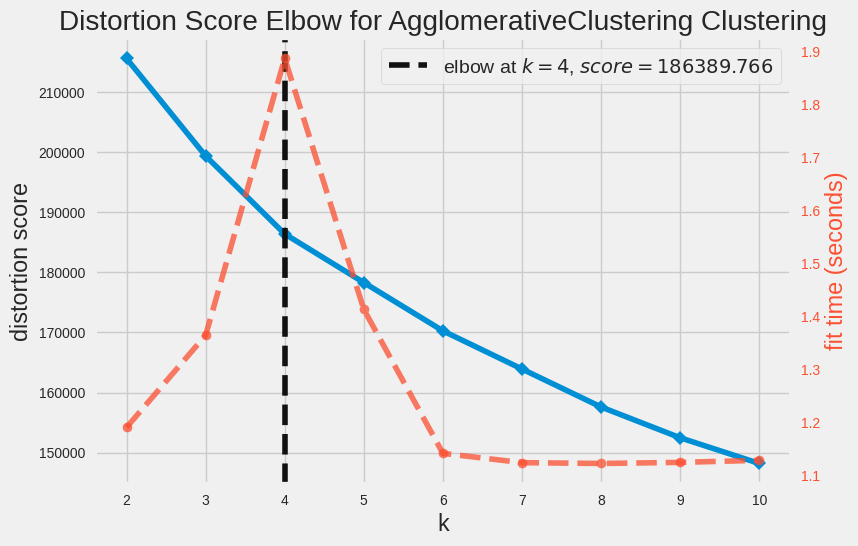

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

# Utilizando o método do cotovelo para descobrir o melhor valor K (número de clusters)
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(2,11))
visualizer.fit(l_we_features)
visualizer.show()

In [ ]:
# Métricas para escolher os Clusters

silhouette_coefficientsL = []
davies_bouldinL = []

linkages = ['ward', 'complete']

for k in range(2,11):
    agg = AgglomerativeClustering (n_clusters = k, linkage=linkage[0])
    agg.fit(l_we_features)
    score = silhouette_score(l_we_features, agg.labels_,  metric='euclidean')
    score2 = davies_bouldin_score(l_we_features, agg.labels_)

    silhouette_coefficientsL.append(score)
    davies_bouldinL.append(score2)

Text(0.5, 1.0, 'Davies_Bouldin')

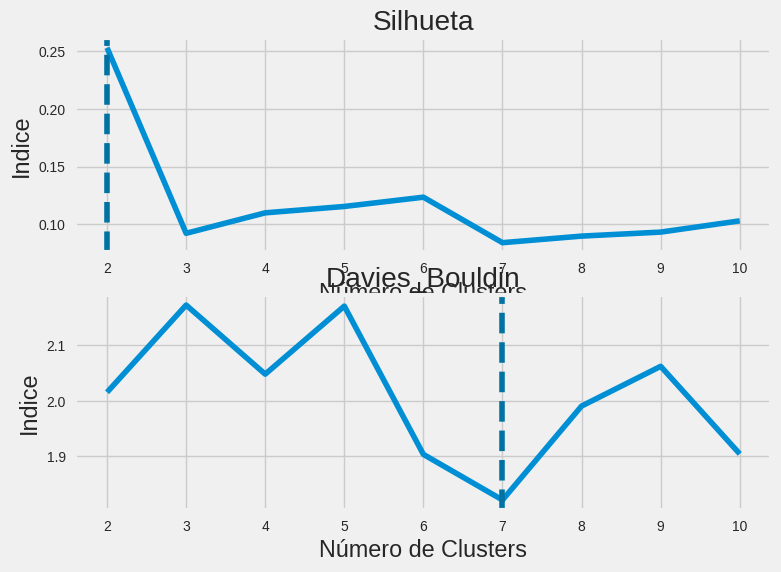

In [ ]:
# Demonstrando as métricas em gráficos - Ward

plt.figure(figsize = (8,9))

plt.subplot(312)
plt.style.use('fivethirtyeight')
plt.plot(range(2,11),silhouette_coefficientsL)
plt.xticks(range(2,11))
plt.xlabel('Número de Clusters')
plt.ylabel('Indice')
plt.axvline(x=2 , color ='b' ,label = 'axvline - full height' , ls='--')
plt.title('Silhueta')

plt.subplot(313)
plt.plot(range(2,11),davies_bouldinL)
plt.xticks(range(2,11))
plt.xlabel('Número de Clusters')
plt.ylabel('Indice')
plt.axvline(x=7 , color ='b' ,label = 'axvline - full height' , ls='--')
plt.title('Davies_Bouldin')


In [ ]:
n_clusters = 2 # Quantiddade de cluster encontrada pela validação da silhueta
clusterAglomerativo = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
y_clusterAglomerativo = clusterAglomerativo.fit_predict(ml_we_features)

unico, contagens = np.unique(y_clusterAglomerativo, return_counts=True)
total = sum(contagens)
porcentagemDosClusters = [f'{contagem/total*100:.2f}%' for contagem in contagens]
for i, porcentagem in enumerate(porcentagemDosClusters):
  print("O cluster {} possui {}% dos elementos" .format(i + 1, porcentagem))

n_clusters = 2 # Quantiddade de cluster encontrada pela validação da silhueta
clusterAglomerativo = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='complete')
y_clusterAglomerativo = clusterAglomerativo.fit_predict(ml_we_features)

unico, contagens = np.unique(y_clusterAglomerativo, return_counts=True)
total = sum(contagens)
porcentagemDosClusters = [f'{contagem/total*100:.2f}%' for contagem in contagens]
for i, porcentagem in enumerate(porcentagemDosClusters):
  print("O cluster {} possui {}% dos elementos" .format(i + 1, porcentagem))

O cluster 1 possui 72.60%% dos elementos
O cluster 2 possui 27.40%% dos elementos
O cluster 1 possui 0.27%% dos elementos
O cluster 2 possui 99.73%% dos elementos


In [ ]:
n_clusters = 4
clusterAglomerativo = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
y_clusterAglomerativo = clusterAglomerativo.fit_predict(ml_we_features)

unico, contagens = np.unique(y_clusterAglomerativo, return_counts=True)
total = sum(contagens)
porcentagemDosClusters = [f'{contagem/total*100:.2f}%' for contagem in contagens]
for i, porcentagem in enumerate(porcentagemDosClusters):
  print("O cluster {} possui {}% dos elementos" .format(i + 1, porcentagem))

O cluster 1 possui 47.09%% dos elementos
O cluster 2 possui 3.88%% dos elementos
O cluster 3 possui 25.51%% dos elementos
O cluster 4 possui 23.53%% dos elementos
